## Set up Environment

In [1]:
suppressPackageStartupMessages(library(DESeq2))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(matrixStats))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library("argparse"))

In [12]:
FD_DATA = file.path(
    "/data/reddylab/Alex/collab/20201029_Graham", 
    "processing",
    "rna_seq",
    "Johnson12_6578_201022B7-pe-revstranded-with-sjdb")
FN_DATA="A549.rnaseq.all.counts.txt"
FP_DATA=file.path(FD_DATA, FN_DATA)

FD_INFO = file.path(
    "/data/reddylab/Alex/collab/20201029_Graham", 
    "data",
    "rna_seq",
    "metadata"
)
FN_INFO = "deseq.samples_info_df.txt"
FP_INFO = file.path(FD_INFO, FN_INFO)

args = list(
    treatments = c(
        "A549.rnaseq.AZD2906.LPS.rep1",
        "A549.rnaseq.AZD2906.LPS.rep3",
        "A549.rnaseq.AZD2906.LPS.rep4",
        "A549.rnaseq.AZD2906.LPS.rep5"
    ),
    controls = c(
        "A549.rnaseq.DMSO.LPS.rep1",
        "A549.rnaseq.DMSO.LPS.rep3",
        "A549.rnaseq.DMSO.LPS.rep4",
        "A549.rnaseq.DMSO.LPS.rep5"
    ),
    counts = FP_DATA,
    counts_skip_ncols=3,
    counts_only_treatments_and_controls=TRUE,
    no_filter=FALSE,
    norm_by_ercc=FALSE,
    lib_sizes=NULL,
    no_model_reps=FALSE,
    samples_info_df=NULL
    #samples_info_df=FP_INFO
    #design-formula="~ rep + drug"
)

In [13]:
treatments = args$treatments
controls   = args$controls

## Import Data

In [14]:
ff = args$counts
dd = lapply(ff, read.csv, header=TRUE, sep="\t", stringsAsFactors=FALSE, row.names=1)
xx = do.call(cbind, dd)

print(class(xx))
print(dim(xx))
xx[1:6, 1:6]

[1] "data.frame"
[1] 60483   102


,Chr,Start,End,A549.rnaseq.AZD2906.LPS.rep1,A549.rnaseq.AZD2906.LPS.rep3,A549.rnaseq.AZD2906.LPS.rep4
ENSG00000223972.5,chr1;chr1;chr1;chr1,11869;12613;12975;13221,12227;12721;13052;14409,0,0,5
ENSG00000227232.5,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1,14404;15005;15796;16607;16858;17233;17606;17915;18268;24738;29534,14501;15038;15947;16765;17055;17368;17742;18061;18366;24891;29570,35,1,37
ENSG00000278267.1,chr1,17369,17436,2,0,8
ENSG00000243485.3,chr1;chr1;chr1,29554;30267;30976,30039;30667;31109,0,0,0
ENSG00000274890.1,chr1,30366,30503,0,0,0
ENSG00000237613.2,chr1;chr1;chr1,34554;35245;35721,35174;35481;36081,0,0,0


In [15]:
countData <- xx
if (!is.null(args$counts_skip_ncols)){
    countData <- xx[, -c(1:args$counts_skip_ncols)]
}

print(class(countData))
print(dim(countData))
countData[1:6, 1:6]

[1] "data.frame"
[1] 60483    99


,A549.rnaseq.AZD2906.LPS.rep1,A549.rnaseq.AZD2906.LPS.rep3,A549.rnaseq.AZD2906.LPS.rep4,A549.rnaseq.AZD2906.LPS.rep5,A549.rnaseq.AZD2906.noLPS.rep1,A549.rnaseq.AZD2906.noLPS.rep2
ENSG00000223972.5,0,0,5,6,0,1
ENSG00000227232.5,35,1,37,62,31,24
ENSG00000278267.1,2,0,8,12,1,0
ENSG00000243485.3,0,0,0,1,0,0
ENSG00000274890.1,0,0,0,0,0,0
ENSG00000237613.2,0,0,0,0,0,0


In [16]:
if (args$counts_only_treatments_and_controls){
#     countData <- xx %>% select(unlist(append(treatments, controls)))
    countData <- subset(xx, select = colnames(countData)[colnames(countData)%in%append(treatments, controls)])
}

print(class(countData))
print(dim(countData))
countData[1:6, 1:6]

[1] "data.frame"
[1] 60483     8


,A549.rnaseq.AZD2906.LPS.rep1,A549.rnaseq.AZD2906.LPS.rep3,A549.rnaseq.AZD2906.LPS.rep4,A549.rnaseq.AZD2906.LPS.rep5,A549.rnaseq.DMSO.LPS.rep1,A549.rnaseq.DMSO.LPS.rep3
ENSG00000223972.5,0,0,5,6,7,2
ENSG00000227232.5,35,1,37,62,41,43
ENSG00000278267.1,2,0,8,12,5,1
ENSG00000243485.3,0,0,0,1,0,0
ENSG00000274890.1,0,0,0,0,0,0
ENSG00000237613.2,0,0,0,0,0,0


## Create Metadata

In [17]:
samples_no_reps <- gsub("(.*)\\..*", "\\1", colnames(countData))
reps            <- gsub(".*\\.(.*)", "\\1", colnames(countData))

conditions           <- samples_no_reps
conditions_pair      <- unique(conditions)
control_conditions   <- unique(gsub("(.*)\\..*", "\\1", controls))
treatment_conditions <- unique(gsub("(.*)\\..*", "\\1", treatments))

cat("+++++++++++++++++++++++++++++++++++++++++++++\n")
cat("reps:", reps, "\n")
cat("+++++++++++++++++++++++++++++++++++++++++++++\n")
cat("conditions:  \n")
for (condition in conditions){print(condition)}
cat("+++++++++++++++++++++++++++++++++++++++++++++\n")
cat("conditions_pair:     ", conditions_pair, "\n")
cat("+++++++++++++++++++++++++++++++++++++++++++++\n")
cat("control_conditions:  ", control_conditions, "\n")
cat("+++++++++++++++++++++++++++++++++++++++++++++\n")
cat("treatment_conditions:", treatment_conditions, "\n")

+++++++++++++++++++++++++++++++++++++++++++++
reps: rep1 rep3 rep4 rep5 rep1 rep3 rep4 rep5 
+++++++++++++++++++++++++++++++++++++++++++++
conditions:  
[1] "A549.rnaseq.AZD2906.LPS"
[1] "A549.rnaseq.AZD2906.LPS"
[1] "A549.rnaseq.AZD2906.LPS"
[1] "A549.rnaseq.AZD2906.LPS"
[1] "A549.rnaseq.DMSO.LPS"
[1] "A549.rnaseq.DMSO.LPS"
[1] "A549.rnaseq.DMSO.LPS"
[1] "A549.rnaseq.DMSO.LPS"
+++++++++++++++++++++++++++++++++++++++++++++
conditions_pair:      A549.rnaseq.AZD2906.LPS A549.rnaseq.DMSO.LPS 
+++++++++++++++++++++++++++++++++++++++++++++
control_conditions:   A549.rnaseq.DMSO.LPS 
+++++++++++++++++++++++++++++++++++++++++++++
treatment_conditions: A549.rnaseq.AZD2906.LPS 


-----
## Set up Expression Matrix

Reorder condition comparisons to always compute log2 fold changes of treat vs control

In [18]:
if (!is.null(args$samples_info_df)){
    colData <- read.csv(args$samples_info_df, 
                        header=TRUE, sep="\t", 
                        stringsAsFactors=TRUE, row.names=1)
    colData <- colData[colnames(countData), ]
    design_formula_str <- paste(c("~ ", paste(colnames(colData), collapse = " + ")), collapse='')
    if (!is.null(args$design_formula)){
        design_formula_str <- args$design_formula
    }
    print(design_formula_str); print("HAHA")
    dds <- DESeqDataSetFromMatrix(countData = countData,
                                  colData = colData,
                                  design = formula(design_formula_str))
    intgroup <- colnames(colData)  # For PCA plots
} else {
    intgroup <- c("condition")  # For PCA plots
    colData <- data.frame(condition=conditions, rep=reps, row.names=colnames(countData))    
    if (!(args$no_model_reps)){
        print(reps)
    #     colData <- data.frame(condition=conditions, rep=reps, row.names=colnames(countData))
        dds <- DESeqDataSetFromMatrix(countData = countData,
                                      colData = colData,
                                      design = ~ rep + condition)
    } else {
    #     colData <- data.frame(condition=conditions, row.names=colnames(countData))
        dds <- DESeqDataSetFromMatrix(countData = countData,
                                      colData = colData,
                                      design = ~ condition)
    }
    # Relevel to setup control as reference
    dds$condition <- relevel(dds$condition, ref = control_conditions)
} 

[1] "rep1" "rep3" "rep4" "rep5" "rep1" "rep3" "rep4" "rep5"


In [21]:
# Optionally: if lib_sizes provided, manually assigned scale factors
if (!is.null(args$lib_sizes)){
    lib_sizes <- read.table(args$lib_sizes, sep="\t", row.names=1)
    lib_sizes <- lib_sizes[colnames(countData), ]
    lib_sizes_scale_factors <- lib_sizes/min(lib_sizes)
    sizeFactors(dds) <- lib_sizes_scale_factors    
}

In [22]:
if (args$norm_by_ercc){
    ercc_genes <- countData[grepl("^ERCC", rownames(countData)), ]
    dds <- DESeqDataSetFromMatrix(countData = countData[!grepl("^ERCC", rownames(countData)), ],
                              colData = colData,
                              design = ~ condition)
    ercc_dds <- DESeqDataSetFromMatrix(countData = ercc_genes, 
                                       colData = colData,
                                       design = ~ condition)
    sizeFactors(dds) <-  sizeFactors(estimateSizeFactors(ercc_dds))
    # Relevel to setup control as reference
    dds$condition <- relevel(dds$condition, ref = control_conditions)
}

In [23]:
# Pre-filtering low count genes
# dds <- dds[ rowSums(counts(dds)) > 5, ]
if (!args$no_filter){
    dds <- dds[ rowSums(fpm(dds, robust = FALSE)>=2) > 1, ]
}

## Run DESeq2

In [24]:
# Run DESeq2
# dds <- DESeq(dds, betaPrior=FALSE)
if (is.character(args$control_substr)){
    control_idxs <- which(grepl(args$control_substr, rownames(countData)))
    dds <- estimateSizeFactors(dds, controlGenes=control_idxs)
} else {
    dds <- estimateSizeFactors(dds)
}
dds <- estimateDispersions(dds)
dds <- nbinomWaldTest(dds)

gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates


## Create PCA plot for the first and second PCs

In [25]:
# Calculate comparison string name 
treat_vs_contr <- paste0(treatment_conditions, '_vs_', control_conditions)

In [26]:
# Extracting transformed values for PCA analysis
vsd <- tryCatch({
    vst(dds, blind=FALSE)
}, error = function(e){
    varianceStabilizingTransformation(dds, blind=FALSE)
})

In [ ]:
# Create PCA plot for the first and second PCs

## Get the results

In [28]:
# Print out result names
resultsNames(dds)

[1] "Intercept"                                                
[2] "rep_rep3_vs_rep1"                                         
[3] "rep_rep4_vs_rep1"                                         
[4] "rep_rep5_vs_rep1"                                         
[5] "condition_A549.rnaseq.AZD2906.LPS_vs_A549.rnaseq.DMSO.LPS"

In [30]:
res <- results(dds, 
               contrast=c('condition', 
                          conditions_pair[conditions_pair %in% treatment_conditions],
                          conditions_pair[conditions_pair %in% control_conditions]), 
               alpha=0.05, 
               independentFiltering=F)  # TODO: Test how the results look without independent filtering

In [31]:
# Shrink log2 fold-change values?
if (!is.null(args$lfcShrink)){
    # If lfcShrinkage specified, save unshrunk values
    resOrdered <- res[order(res$padj),]

    # Save sorted results in a text file
    write.table(resOrdered, 
                file=paste0(outdir, '/', treat_vs_contr, '.unshrunk.txt'),
                quote = FALSE, row.names=TRUE, sep = '\t')

    # Create plot for the log2 fold changes from the treatment over the mean of normalized counts
    pdf(paste0(outdir, '/', treat_vs_contr, '.unshrunk.pdf'))
    log2fc_lim <- ceiling(max(max(res$log2FoldChange), abs(min(res$log2FoldChange))))
    plotMA(res, main=paste0("DESeq2_unshrunk_lfc_", treat_vs_contr), ylim=c(-log2fc_lim,log2fc_lim))
    dev.off()

    # Calculate lfcShrink values
    targ_contrast <- paste0("condition_", treat_vs_contr)
    res <- lfcShrink(dds, 
                     coef=targ_contrast, 
                     type=args$lfcShrink)
}

# Sort by adjusted p-value (FDR)
(resOrdered <- res[order(res$padj),])

# Print out summary of results
summary(resOrdered, alpha=0.05)

log2 fold change (MLE): condition A549.rnaseq.AZD2906.LPS vs A549.rnaseq.DMSO.LPS 
Wald test p-value: condition A549.rnaseq.AZD2906.LPS vs A549.rnaseq.DMSO.LPS 
DataFrame with 12772 rows and 6 columns
                           baseMean        log2FoldChange             lfcSE
                          <numeric>             <numeric>         <numeric>
ENSG00000115112.7  4151.46846337252      4.97751451614244 0.222123078644949
ENSG00000096060.13 10512.0777262875      4.06502413302087  0.20098980552904
ENSG00000157514.15 7160.94897182517       3.5956508261672 0.184739854779551
ENSG00000139132.13 2928.35302278316      3.99013610179226 0.241708255759083
ENSG00000108691.8  870.386489132937      -3.4726594979936 0.217818256108256
...                             ...                   ...               ...
ENSG00000113732.7  7791.54209854316 -5.72619163301535e-05 0.173585155793762
ENSG00000164919.9  4434.27786953497 -6.24867278204838e-05 0.227904513552794
ENSG00000090581.8  1156.11946304206   6


out of 12772 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 536, 4.2%
LFC < 0 (down)     : 248, 1.9%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [32]:
# Try IHW multiple hypothesis testing package
library("IHW")
resIHW <- results(dds, 
                  alpha=0.05,
                  contrast=c('condition', 
                          conditions_pair[conditions_pair %in% treatment_conditions],
                          conditions_pair[conditions_pair %in% control_conditions]),
                  filterFun=ihw
                 )
summary(resIHW, alpha=0.05)
resIHW <- resIHW[order(resIHW$padj),]


Attaching package: ‘IHW’

The following object is masked from ‘package:ggplot2’:

    alpha




out of 12772 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 539, 4.2%
LFC < 0 (down)     : 246, 1.9%
outliers [1]       : 0, 0%
[1] see 'cooksCutoff' argument of ?results
see metadata(res)$ihwResult on hypothesis weighting



```
# Create plot for the log2 fold changes from the treatment over the mean of normalized counts
log2fc_lim <- ceiling(max(max(res$log2FoldChange), abs(min(res$log2FoldChange))))
pdf(paste0(outdir, '/', treat_vs_contr, '.pdf'))
plotMA(res, main=paste0("DESeq2_", treat_vs_contr), ylim=c(-log2fc_lim,log2fc_lim))
dev.off()

# Create plot for dispersion of normalized counts
pdf(paste0(outdir, '/', treat_vs_contr, '.mean_counts_dispersion.pdf'))
plotDispEsts(dds)
dev.off()
```

# Create plot for the log2 fold changes from the treatment over the mean of normalized counts

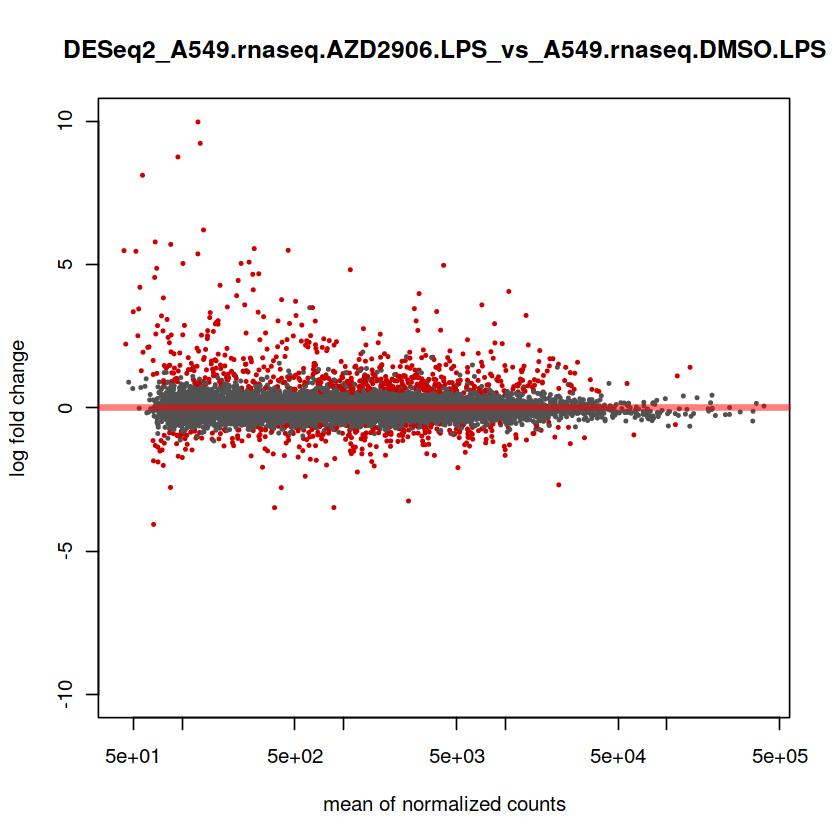

In [34]:
# Create plot for the log2 fold changes from the treatment over the mean of normalized counts
log2fc_lim <- ceiling(max(max(res$log2FoldChange), abs(min(res$log2FoldChange))))
plotMA(res, main=paste0("DESeq2_", treat_vs_contr), ylim=c(-log2fc_lim,log2fc_lim))

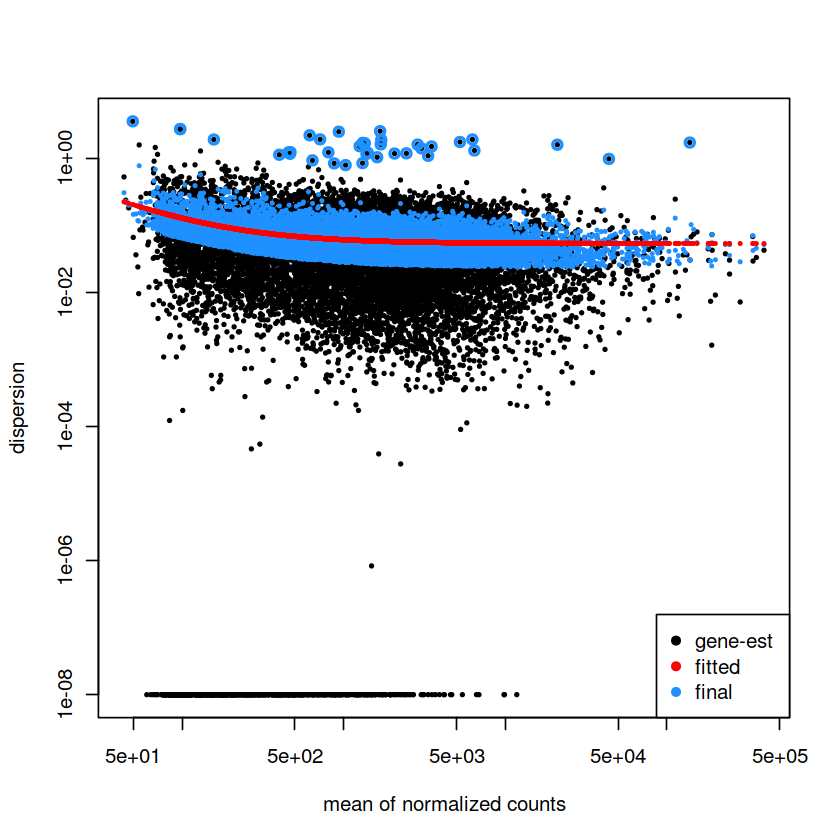

In [35]:
# Create plot for dispersion of normalized counts
plotDispEsts(dds)

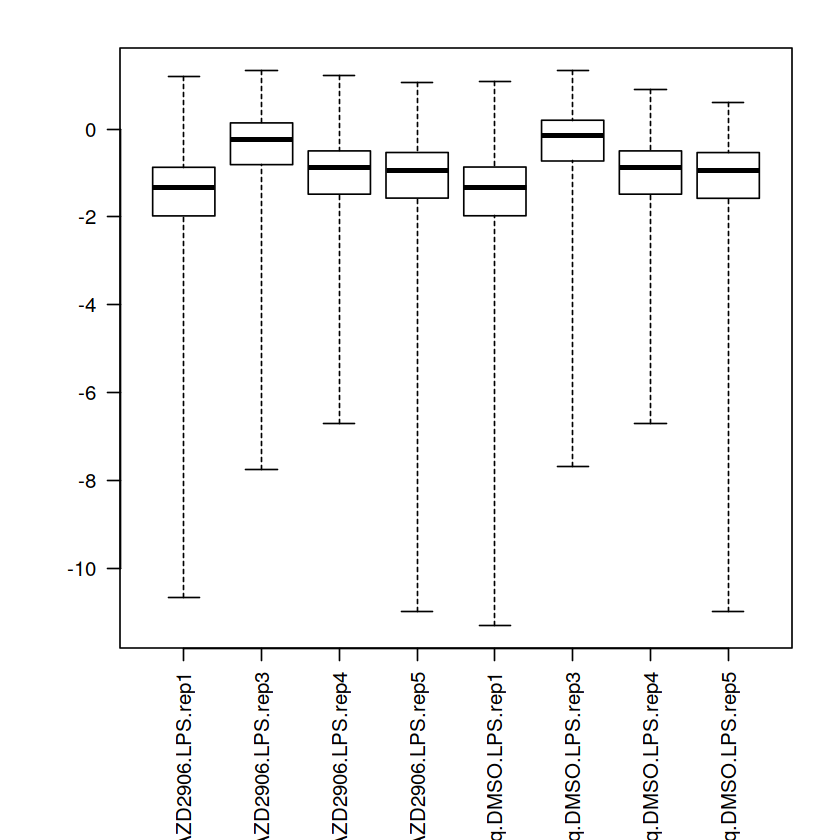

In [36]:
# To check if there are too many outliers, plot the Cook distances
par(mar=c(8,5,2,2))
boxplot(log10(assays(dds)[["cooks"]]), range=0, las=2)

## Save results

```
# Save sorted results in a text file
write.table(resOrdered, 
            file=paste0(outdir, '/', treat_vs_contr, '.txt'),
            quote = FALSE, row.names=TRUE, sep = '\t')

# Save IHW results in a text file
write.table(resIHW, 
            file=paste0(outdir, '/', treat_vs_contr, '.IHW.txt'),
            quote = FALSE, row.names=TRUE, sep = '\t')

# Save vsd transformed values
write.table(assay(vsd), 
            file=paste0(outdir, '/', treat_vs_contr, '.vsd.txt'),
            quote = FALSE, row.names=TRUE, sep = '\t')


rld <- rlog(dds) # rlog transformed values (typically used for clustering - see DESeq2 manual for details)
# Save rlog transformed values
write.table(assay(rld), 
            file=paste0(outdir, '/', treat_vs_contr, '.rlog.txt'),
            quote = FALSE, row.names=TRUE, sep = '\t')

# Save .RData object
save.image(paste0(outdir, '/', treat_vs_contr, '.RData'))

cat("Done!")

```